# Снижение расходов на маркетинг в Яндекс.Афише
**Цель проекта**: снизить расходы с помощью отказа от невыгодных источников трафика и перераспределить бюджет.

**Задачи проекта**:
- Изучить, как клиенты пользуются сервисом,
- Выявить, когда клиенты делают первые покупки на сайте,
- Определить, сколько денег приносит компании каждый клиент,
- Выявить, когда расходы на привлечение клиента окупаются.

Для реализации проекта будут использованы: данные Яндекс.Афиши с июня 2017 по конец мая 2018 года и инструменты Python.

**Этапы исследования**:
1. [Подготовка данных](#start)
2. [Расчёт продуктовых метрик](#product)
    - [Расчёт DAU, WAU и MAU](#type)
    - [Определение среднего количества посещений сайта](#count)
    - [Исследование проведенного на сайте времени](#time)  
    - [Расчёт Retention Rate](#retention_rate)
3. [Метрики электронной коммерции](#ecommerce)
    - [Расчёт среднего времени первой покупки](#time)
    - [Определение среднего количества покупок на покупателя](#buy)
    - [Расчёт среднего чека](#apv)
    - [Изучение динамики LTV](#ltv)
4. [Маркетинговые метрики](#marketing)
    - [Изучение распределения расходов на маркеинг](#costs)
    - [Расчёт среднего CAC](#cac)
    - [Расчёт ROMI](#romi)
5. [Вывод и рекомендации](#conclusion)

## [Подготовка данных](#start)
На этапе подготовки данных импортируем все необходимые для реализации проекта библиотеки и откроем данные таблиц, чтобы оценить, что нужно будет сделать на этапе предобработки.

In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [49]:
try:
    visits_log = pd.read_csv('/content/visits_log.csv')
except:
    visits_log = pd.read_csv('/datasets/visits_log.csv')
visits_log.info()
visits_log.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [50]:
visits_log.columns = visits_log.columns.str.lower()
visits_log.rename(columns={'end ts':'end_ts', 'source id':'source_id', 'start ts':'start_ts'}, inplace=True)
visits_log.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [51]:
try:
    orders_log = pd.read_csv('/content/orders_log.csv')
except:
    orders_log = pd.read_csv('/datasets/orders_log.csv')
orders_log.info()
orders_log.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [52]:
orders_log.columns = orders_log.columns.str.lower()
orders_log.rename(columns={'buy ts':'buy_ts'}, inplace=True)
orders_log.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [53]:
try:
    costs = pd.read_csv('/content/costs.csv')
except:
    costs = pd.read_csv('/datasets/costs.csv')
costs.info()
costs.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [54]:
visits_log.isna().mean()

device       0.0
end_ts       0.0
source_id    0.0
start_ts     0.0
uid          0.0
dtype: float64

In [55]:
visits_log['start_ts'] = visits_log['start_ts'].fillna(visits_log['end_ts'])

В ходе первичной обработки существенных неточностей в данных, которые трбовали бы их изменения, выявлено не было. Есть один пропуск данных в строке начала сессии. Возможно система сработала некорректно и, например, время сессии истекло и в этот же момент клиент закрыл вкладку с сайтом. В любом случае вес данного пропуска очень мал, поэтому мы заменили пропуск на время окончания сессии. А также заменили имена столбцов для удобства в дальнейшей обработке информации.

## [Расчёт продуктовых метрик](#product)
**[Расчёт DAU, WAU и MAU](#type)**

Для решения задачи снижения рсходов на маркетинг предварительно необходимо изучить поведение пользователей сайта. Изучим количество активных пользователей в разрезе дня, недели, месяца. 


In [56]:
visits_log['start_ts'] = pd.to_datetime(visits_log['start_ts'], format='%Y-%m-%d %H:%M:%S')
visits_log['end_ts'] = pd.to_datetime(visits_log['end_ts'], format='%Y-%m-%d %H:%M:%S')

#выделим в отдельные столбцы год, месяц и неделю, а также полную дату
visits_log['session_year']  = visits_log['start_ts'].dt.year
visits_log['session_month'] = visits_log['start_ts'].dt.month
visits_log['session_week']  = visits_log['start_ts'].dt.week
visits_log['session_date'] = visits_log['start_ts'].dt.date

visits_log.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [57]:
dau_total = visits_log.groupby('session_date').agg({'uid': 'nunique'})

wau_total = (
    visits_log.groupby(['session_year', 'session_week'])
    .agg({'uid': 'nunique'})
)

mau_total = (
    visits_log.groupby(['session_year', 'session_month'])
    .agg({'uid': 'nunique'})
)

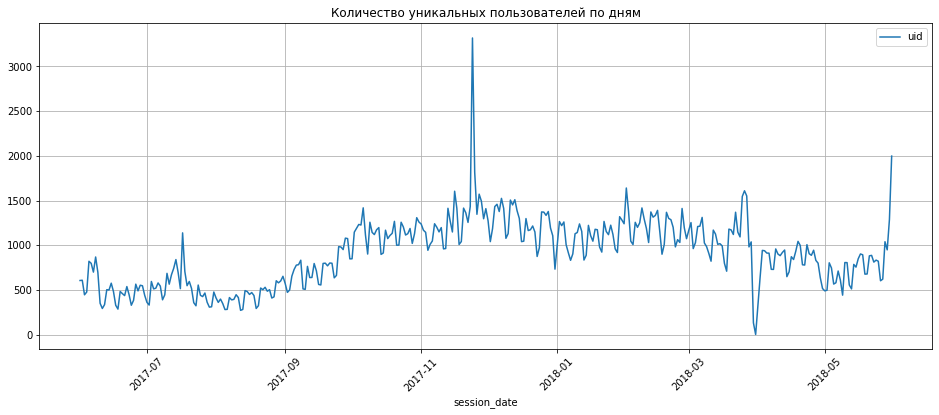

In [58]:
dau_total.plot(figsize=(16,6), grid=True, title='Количество уникальных пользователей по дням')
plt.xticks(rotation=45)
plt.show()
plt.close()

In [59]:
dau_total.describe()

,uid
count,364.000000
mean,907.991758
std,370.513838
min,1.000000
25%,594.000000
50%,921.000000
75%,1173.000000
max,3319.000000


In [60]:
dau_total.mean()

uid    907.991758
dtype: float64

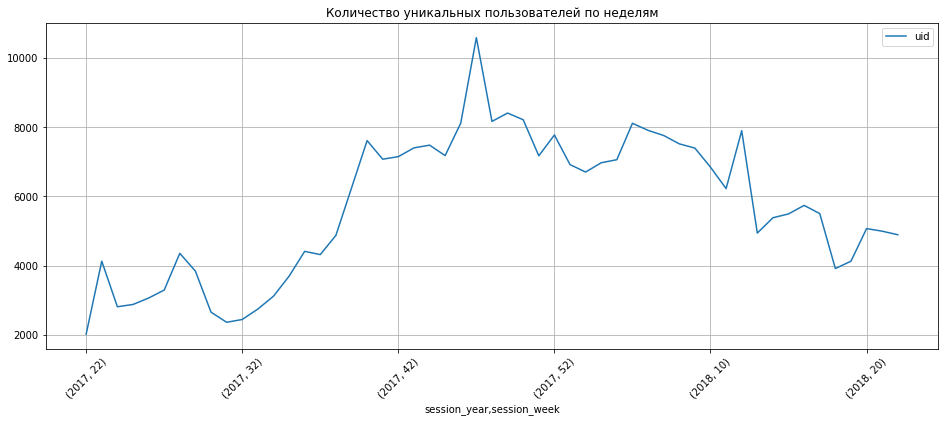

In [61]:
wau_total.plot(figsize=(16,6), grid=True, title='Количество уникальных пользователей по неделям')
plt.xticks(rotation=45)
plt.show()
plt.close()

In [62]:
wau_total.describe()

,uid
count,53.000000
mean,5716.245283
std,2049.898027
min,2021.000000
25%,4128.000000
50%,5740.000000
75%,7401.000000
max,10586.000000


In [63]:
wau_total.mean()

uid    5716.245283
dtype: float64

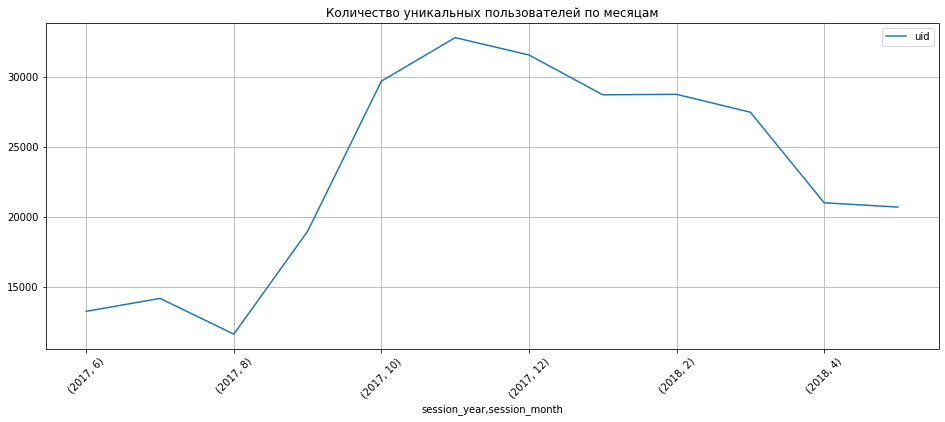

In [64]:
mau_total.plot(figsize=(16,6), grid=True, title='Количество уникальных пользователей по месяцам')
plt.xticks(rotation=45)
plt.show()
plt.close()

In [65]:
mau_total.describe()

,uid
count,12.000000
mean,23228.416667
std,7546.380462
min,11631.000000
25%,17777.000000
50%,24240.500000
75%,28984.750000
max,32797.000000


In [66]:
mau_total.mean()

uid    23228.416667
dtype: float64

В результате изучения количества активных пользователей в разрезе дня, недели, месяца было выявлено, что:

* Среднее количество активных пользователей в день: 908;
* Среднее количество активных пользователей в неделю: 5 716;
* Среднее количество активных пользователей в месяц: 23 228.


На графиках видно, что пик по всем метрикам был достаточно ожидаемо в декабре. Ежедневное посещение сайта возрастало примерно до октября 2017, что скорее всего связано с развитием маркетинга на сайте. Потом количество пользователей колебалось в районе 1000-1500 с пиком в декабре и такой же динамикой до марта. В апреле заметен небольшой подъем и резкий спад. За весь рассматриваемый период в среднем ежедневно на сайте были активны 907 пользоваталей.

По неделям в начале идет резкий подъем количества посетелей на 35-40 неделях, а потом умеренный спад с 49 недели. В среднем каждую неделю на сайте активны почти 6 тысяч пользователей.

Помесячное количество посещений говорит о том, что меньше всего на сайт заходили в августе 2018, что возможно свзано с сезоном отпусков и незаинтересованностью пользователей в различного рода мероприятиях, т.к. многих в этот период вообще нет в городе. С августа по октябрь был стремительный рост, пик наблюдается в ноябре, а далее идет спад и стагнация с апреля по июнь 2018. В среднем в месяц на сайт заходят 23 тысячи пользователей.

**[Определение среднего количества посещений сайта](#count)**

In [67]:
visits_daily = visits_log.groupby(['session_date', 'uid']).agg({'uid': 'count'})
visits_daily.rename(columns={'uid':'sessions'}, inplace=True)
display(visits_daily)

sessions
session_date uid                           
2017-06-01   32197920403662046            1
             184148767273119549           2
             254239507810036143           1
             258099436367309303           1
             300776506671194537           1
...                                     ...
2018-05-31   18413292963150477112         1
             18428173890345346536         1
             18428797902626915731         1
             18438521692156628706         1
             18438729003678071174         1

[330509 rows x 1 columns]

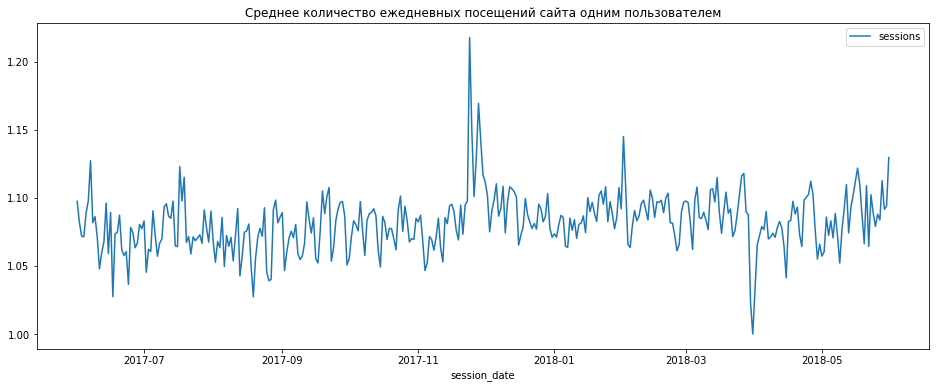

In [68]:
(visits_daily
     .pivot_table(index='session_date', values='sessions', aggfunc='mean')
     .plot(figsize=(16,6), title='Среднее количество ежедневных посещений сайта одним пользователем')
);
plt.show()
plt.close()

In [69]:
print('Среднее количество посещений сайта в день: ', visits_daily['sessions'].mean())

Среднее количество посещений сайта в день:  1.0874136559064957


Изучив среднее количество ежедневных посещений сайта одним пользователем, можно говорить о том, что в основном люди посещают сайт один раз в день.

Пик ежедневных посещений одним пользователем наблюдается в июне 2018, а в конце августа-сентябре 2017 года пользователи не заходили на сайт больше одного раза в день.

**[Исследование проведенного на сайте времени](#time)** 

In [70]:
visits_log['lifetime'] = (visits_log['end_ts']- visits_log['start_ts']) / np.timedelta64(1, 'm')
visits_log['lifetime'] = visits_log['lifetime'].astype('int')
visits_log['lifetime'].head(10)

0    18
1    28
2     0
3    24
4     0
5     1
6    56
7     1
8     3
9     1
Name: lifetime, dtype: int64

In [71]:
first_client_visit = visits_log.groupby('uid')['session_date'].min()
first_client_visit.name = 'first_visit'

In [72]:
visits_log = visits_log.join(first_client_visit, on='uid')
display(visits_log.head(5))

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,lifetime,first_visit
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,18,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,28,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,24,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,2017-12-27


In [73]:
visits_log['first_visit_month'] = visits_log['first_visit'].astype('datetime64[M]')

visits_log['visit_month'] = visits_log['end_ts'].astype('datetime64[M]')
visits_grouped_by_cohorts = visits_log.groupby(['first_visit_month', 'visit_month']).agg({'uid': 'nunique', 'lifetime': 'mean'})
display(visits_grouped_by_cohorts.head(5))

uid   lifetime
first_visit_month visit_month                  
2017-06-01        2017-06-01   13255   9.998485
                  2017-07-01    1047  15.936672
                  2017-08-01     713  16.340159
                  2017-09-01     814  16.606195
                  2017-10-01     909  16.010452

In [74]:
#проверим, где закралась ошибка и если таких данных немного - скорее всего произошла ошибка в работе сайта
#и эти данные нужно будет отсечь
display(visits_log.query('end_ts < start_ts'))
visits_query = visits_log.query('end_ts > start_ts')

#да, действительно 25 марта 2018 года был какой-то сбой на сайте

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,lifetime,first_visit,first_visit_month,visit_month
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018,3,12,2018-03-25,-32,2017-11-12,2017-11-01,2018-03-01
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018,3,12,2018-03-25,-46,2018-03-19,2018-03-01,2018-03-01


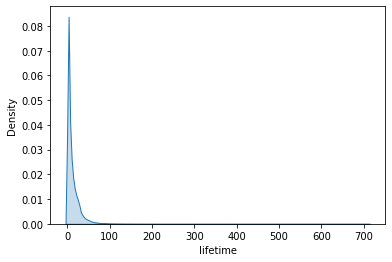

In [75]:
sns.kdeplot(visits_query['lifetime'], shade=True)

In [76]:
visits_query['lifetime'].describe()

count    323604.000000
mean         11.901976
std          17.106407
min           0.000000
25%           2.000000
50%           6.000000
75%          15.000000
max         711.000000
Name: lifetime, dtype: float64

In [77]:
visits_query.mode()['lifetime']

0    1
Name: lifetime, dtype: int64

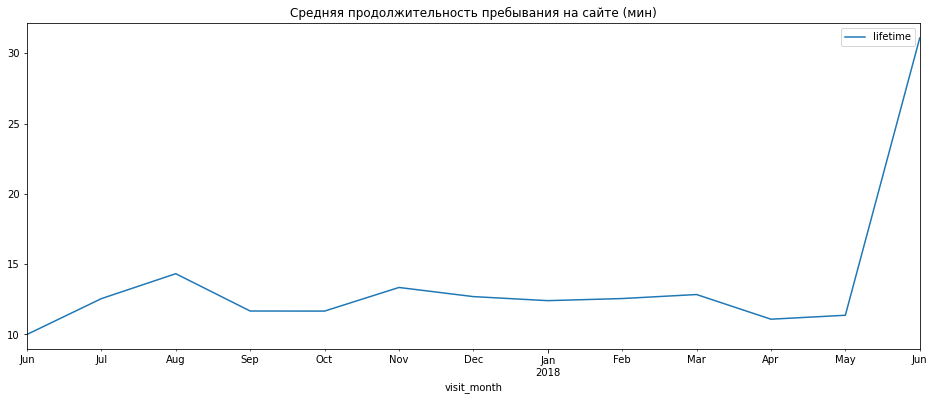

In [78]:
(visits_grouped_by_cohorts
      .pivot_table(index='visit_month',values='lifetime',aggfunc='median')
      .plot(figsize=(16,6), title='Средняя продолжительность пребывания на сайте (мин)')
);
plt.show()
plt.close()

Среднее(медианное) значение пребывания н сайте - 6 минут. Этот показатель говорит о том, что если ранжировать минуты пребывания по порядку - в середине будет 6 минут и, следственно, можно считать это средним значением. Чаще всего пользователи проводят на сайте 1 минуту. В ноябре 2017 года пользователи были активнее и проводили в среднем почти 15 минут. Заметен очень высокий показатель с мая 2018 года, что похоже на техническую ошибку и стоит узнать об этом у отдела разработки. В целом можно говорить о том, что для принятия решения о посещении мероприятия с сайта Яндекс.Афиши полльзователю нужно не больше 6 минут.


**[Расчёт Retention Rate](#retention_rate)**

Retention Rate показывает, сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды.

In [79]:
visits_log['cohort_lifetime'] = (visits_log['visit_month'] - visits_log['first_visit_month'])
visits_log['cohort_lifetime'] = visits_log['cohort_lifetime'] / np.timedelta64(1, 'M')
visits_log['cohort_lifetime'] = visits_log['cohort_lifetime'].round().astype('int') 

In [80]:
cohorts = visits_log.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

#найдем исходное количество в когороте 
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month', 'uid']]
print(initial_users_count)

   first_visit_month    uid
0         2017-06-01  13255
12        2017-07-01  13136
23        2017-08-01  10177
33        2017-09-01  16696
42        2017-10-01  25971
50        2017-11-01  27246
57        2017-12-01  25267
63        2018-01-01  22614
68        2018-02-01  22194
72        2018-03-01  20589
75        2018-04-01  15706
77        2018-05-01  15266


In [81]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 
print(cohorts)

   first_visit_month  cohort_lifetime    uid  cohort_users  retention
0         2017-06-01                0  13255         13255   1.000000
1         2017-06-01                1   1047         13255   0.078989
2         2017-06-01                2    713         13255   0.053791
3         2017-06-01                3    814         13255   0.061411
4         2017-06-01                4    909         13255   0.068578
..               ...              ...    ...           ...        ...
74        2018-03-01                2    557         20589   0.027053
75        2018-04-01                0  15706         15706   1.000000
76        2018-04-01                1    763         15706   0.048580
77        2018-05-01                0  15266         15266   1.000000
78        2018-05-01                1     12         15266   0.000786

[79 rows x 5 columns]


In [82]:
cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m') 

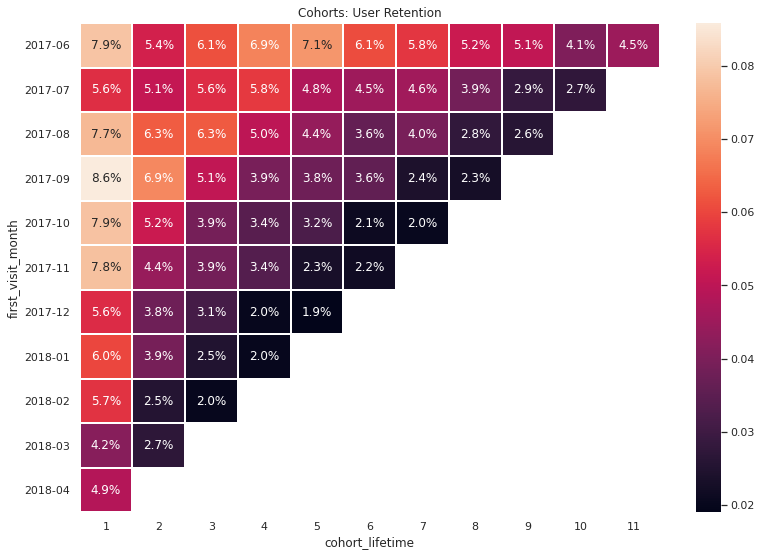

In [83]:
cohorts = cohorts.query('cohort_lifetime != 0 and first_visit_month != "2018-05"')

retention_pivot = cohorts.pivot_table(
    index='first_visit_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
) 

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='white'); 

In [84]:
retention_pivot[1].mean()

0.06535671545807291

Retention Rate в первую неделю убывает по когортам с течением времени. С каждым месяцем коэффициент удержания падает и это говорит о возможно неэффективном маркетинге. В среднем на второй месяц на сайт повторно зашли 6,5% первоначальных пользователей.

## [Метрики электронной коммерции](#ecommerce)
**[Расчёт среднего времени первой покупки](#time)**

In [85]:
orders_log['buy_ts'] = pd.to_datetime(orders_log['buy_ts'], format='%Y-%m-%d %H:%M:%S')

orders_grouped = pd.DataFrame(orders_log.groupby('uid')['buy_ts'].min())
visits_grouped = pd.DataFrame(visits_log.groupby('uid')['start_ts'].min())

orders = visits_grouped.merge(orders_grouped, on='uid').reset_index()
orders['first_order'] = (orders['buy_ts']- orders['start_ts']) / np.timedelta64(1, 'D')
display(orders.head(5))

,uid,start_ts,buy_ts,first_order
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106.959722
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.000000
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0.054861
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0.822222
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.000000


In [86]:
orders['first_order'].describe()

count    36523.000000
mean        16.902900
std         47.072760
min          0.000000
25%          0.002778
50%          0.011111
75%          2.011806
max        363.294444
Name: first_order, dtype: float64

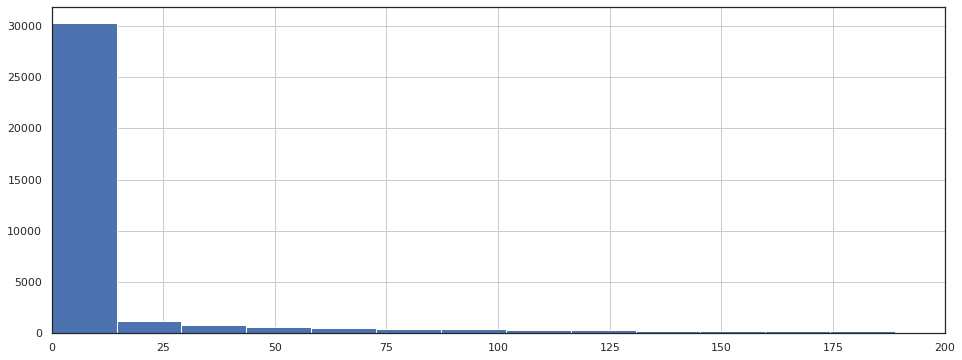

In [87]:
orders['first_order'].hist(figsize=(16,6), bins=25)
plt.xlim(0, 200)
plt.show()
plt.close()

In [88]:
orders['first_order'].median()

0.011111111111111112

Обычно между посещением сайта пользовтаелем и покупкой билетов проходит меньше дня, т.е. пользователь практически сразу принимает решение о посещении того или иного мероприятия.

**[Определение среднего количества покупок на покупателя](#buy)**

In [89]:
orders_log['buy_ts'] = pd.to_datetime(orders_log['buy_ts'], format='%Y-%m-%d %H:%M:%S')

first_order_date_by_customers = orders_log.groupby('uid')['buy_ts'].min()
first_order_date_by_customers.name = 'first_order_date'

orders = orders_log.join(first_order_date_by_customers, on='uid')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

orders['first_order_month'] = orders['first_order_month'].dt.strftime('%Y-%m')
orders['order_month'] = orders['order_month'].dt.strftime('%Y-%m')

print(orders)


                   buy_ts  revenue  ...  first_order_month order_month
0     2017-06-01 00:10:00    17.00  ...            2017-06     2017-06
1     2017-06-01 00:25:00     0.55  ...            2017-06     2017-06
2     2017-06-01 00:27:00     0.37  ...            2017-06     2017-06
3     2017-06-01 00:29:00     0.55  ...            2017-06     2017-06
4     2017-06-01 07:58:00     0.37  ...            2017-06     2017-06
...                   ...      ...  ...                ...         ...
50410 2018-05-31 23:50:00     4.64  ...            2018-05     2018-05
50411 2018-05-31 23:50:00     5.80  ...            2018-05     2018-05
50412 2018-05-31 23:54:00     0.30  ...            2018-05     2018-05
50413 2018-05-31 23:56:00     3.67  ...            2018-05     2018-05
50414 2018-06-01 00:02:00     3.42  ...            2018-06     2018-06

[50415 rows x 6 columns]


In [90]:
cohorts_orders = orders.groupby(['first_order_month' , 'order_month']).agg({'revenue' : 'count', 'uid' : 'nunique'}).reset_index()
cohorts_orders['orders'] = cohorts_orders['revenue'] / cohorts_orders['uid']

cohorts_orders['first_order_month'] = cohorts_orders['first_order_month'].astype('datetime64[M]')
cohorts_orders['order_month'] = cohorts_orders['order_month'].astype('datetime64[M]')

cohorts_orders['age'] = (cohorts_orders['order_month'] - cohorts_orders['first_order_month']) / np.timedelta64(1, 'M')
cohorts_orders['age'] = cohorts_orders['age'].round().astype('int')

cohorts_orders['first_order_month'] = cohorts_orders['first_order_month'].dt.strftime('%Y-%m')

cohorts_orders

,first_order_month,order_month,revenue,uid,orders,age
0,2017-06,2017-06-01,2354,2023,1.163618,0
1,2017-06,2017-07-01,177,61,2.901639,1
2,2017-06,2017-08-01,174,50,3.480000,2
3,2017-06,2017-09-01,226,54,4.185185,3
4,2017-06,2017-10-01,292,88,3.318182,4
...,...,...,...,...,...,...
74,2018-03,2018-05-01,176,58,3.034483,2
75,2018-04,2018-04-01,2495,2276,1.096221,0
76,2018-04,2018-05-01,195,69,2.826087,1
77,2018-05,2018-05-01,3249,2988,1.087349,0


In [91]:
cohorts_orders = cohorts_orders.query('order_month != "2018-06"')

cohorts_order = cohorts_orders.pivot_table(
    index='first_order_month',
    columns='age',
    values='orders',
    aggfunc='mean',
)

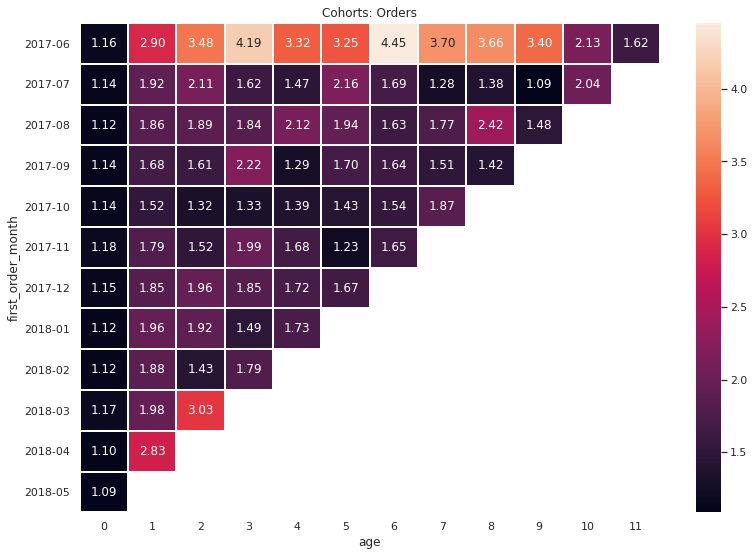

In [92]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Orders')
sns.heatmap(cohorts_order, annot=True, fmt='.2f', linewidths=1, linecolor='white'); 

In [93]:
print('Среднее количество покупок на одного покупателя за полгода:', cohorts_order.median()[5])

Среднее количество покупок на одного покупателя за полгода: 1.703125


На графиках отчетливо видно, что в июне (начале имеющегося отчетного периода) покупатели совершали мало покупок, пользователи начинают активизироваться в сентябре и октябре, что возможно связано с тем, что многие театры уходят на перерыв летом и возвращаются осенью с новыми постановками. К концу ноября пользователи тоже активно совершают покупки, что скорее всего связано с ближайшим наступлением Нового Года и появлением разных приуроченных к этому программ.

Больше всего покупок совершили люди из первой когорты, т.е. зарегестрировавшиеся самыми первыми в рамках данного исследования. В среднем на одного пользователя приходится по 2 покупки.

**[Расчёт среднего чека](#apv)**

In [94]:
average_order = orders_log.groupby(['buy_ts']).agg({'revenue': 'sum', 'uid': 'count'}).reset_index()
average_order['buy_month'] = average_order['buy_ts'].astype('datetime64[M]').dt.strftime('%Y-%m') 
average_order['apv'] = average_order['revenue']/average_order['uid']

In [95]:
average_order['revenue'].describe()

count    45991.000000
mean         5.480577
std         22.922826
min          0.000000
25%          1.400000
50%          2.820000
75%          5.500000
max       2633.280000
Name: revenue, dtype: float64

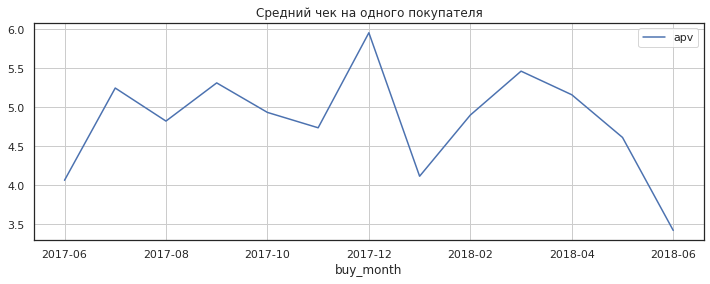

In [96]:
(average_order
     .pivot_table(index='buy_month', values='apv', aggfunc='mean')
     .plot(figsize=(12,4), grid=True, title='Средний чек на одного покупателя')
);
plt.show()
plt.close()

Анализ показателя среднего чека пользователя по месяцам демонстрирует то, что в среднем пользователи покупают на 5,5 денежных единиц в месяц, но в конце декабря люди тратят на посещение мероприятий намного больше (в среднем 2633 ден.ед. на пользователя). Также замечены всплески в марте и апреле, что возможно связано с 8 марта и подарками к нему, а также с проведением какого-то определенного популярного мероприятия.

**[Изучение динамики LTV](#ltv)**

Для того, чтобы оценить покупательскую активность - изучим итоговую сумму денег, которую один клиент приносит в среднем со всех своих покупок.

In [97]:
orders_log['order_month'] = orders_log['buy_ts'].astype('datetime64[M]')
orders_log['order_month'] = orders_log['order_month'].dt.strftime('%Y-%m')

first_orders = orders_log.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

cohort_sizes = (first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index())
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes['first_order_month'] = cohort_sizes['first_order_month'].astype('datetime64[M]')
cohort_sizes['first_order_month'] = cohort_sizes['first_order_month'].dt.strftime('%Y-%m')

print(cohort_sizes.head(5)) 

  first_order_month  n_buyers
0           2017-06      2023
1           2017-07      1923
2           2017-08      1370
3           2017-09      2581
4           2017-10      4340


In [98]:
orders_new = pd.merge(orders_log,first_orders, on='uid')

cohorts = (
    orders_new.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)

print(cohorts.head(5))

  first_order_month order_month  revenue
0           2017-06     2017-06  9557.49
1           2017-06     2017-07   981.82
2           2017-06     2017-08   885.34
3           2017-06     2017-09  1931.30
4           2017-06     2017-10  2068.58


In [99]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
print(report.head(5))

  first_order_month  n_buyers order_month  revenue
0           2017-06      2023     2017-06  9557.49
1           2017-06      2023     2017-07   981.82
2           2017-06      2023     2017-08   885.34
3           2017-06      2023     2017-09  1931.30
4           2017-06      2023     2017-10  2068.58


In [100]:
margin_rate = 1

report['gp'] = report['revenue'] * margin_rate

report['order_month'] = report['order_month'].astype('datetime64[M]') 
report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')

report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
print(report.head())

  first_order_month  n_buyers order_month  revenue       gp  age
0        2017-06-01      2023  2017-06-01  9557.49  9557.49    0
1        2017-06-01      2023  2017-07-01   981.82   981.82    1
2        2017-06-01      2023  2017-08-01   885.34   885.34    2
3        2017-06-01      2023  2017-09-01  1931.30  1931.30    3
4        2017-06-01      2023  2017-10-01  2068.58  2068.58    4


In [101]:
report['ltv'] = report['gp'] / report['n_buyers']
output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='sum').round(2)
output = output.cumsum(axis=1)
output

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.40,NaN
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.37,7.58,7.99,8.28,8.47,NaN,NaN
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,NaN,NaN,NaN
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,5.00,5.93,7.00,7.31,7.65,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,4.43,4.73,4.87,4.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,4.44,4.52,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


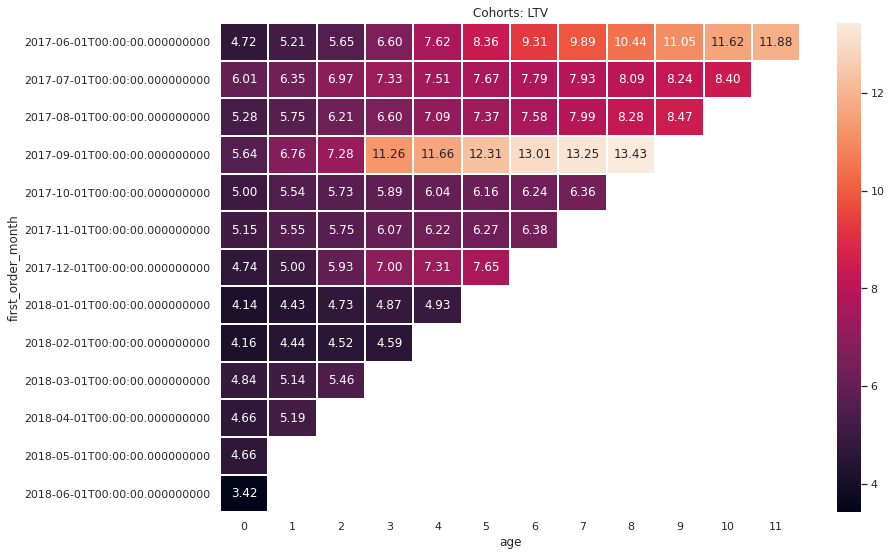

In [102]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: LTV')
sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='white');

In [103]:
print('Средний LTV за 6 месяцев:', output.mean(axis=0)[5])

Средний LTV за 6 месяцев: 7.970000000000001


Можно говорить о том, что в среднем за 6 месяцев пользователь приносит 8 денежных единиц.


## [Маркетинговые метрики](#marketing)
Маркетинговые метрики - показатели, с помощью анализа которых можно изменить стоимость привлечения одного клиента, отказавшись от невыгодных источников трафика.

**[Изучение распределения расходов на маркеинг](#costs)**

In [104]:
expense = costs.groupby('source_id')['costs'].sum()
display(expense)
print('Общая сумма расходов на маркетинг составила: ', expense.sum().round(2))

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Общая сумма расходов на маркетинг составила:  329131.62


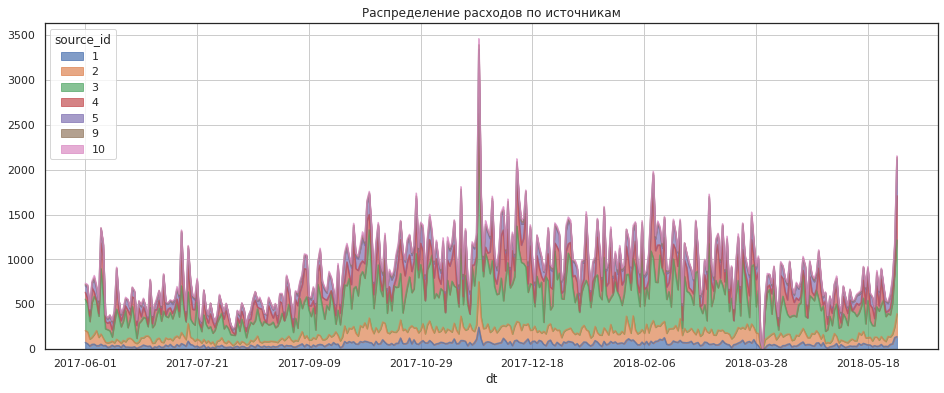

In [105]:
(costs
      .pivot_table(index='dt', columns='source_id', values='costs', aggfunc='sum')
      .plot(kind='area', figsize=(16,6), legend=True, grid=True, alpha=0.7, title='Распределение расходов по источникам')
);

На графике отчетливо видно, что больше всего было затрачено на 3 источник трафика. По всем источникам трафика наблюдается римерно одинаковая динамика. Очень ярко выделяется период конца ноября - начала декабря, когда маркетинг потратил больше всего денег. Но также стоит отметить, что на основе анализа продуктовых метрик и метрик электронной коммерции - такое вложение было оправдано.

Общая сумма расходов на маркетинг составила 329131,62 ден.ед. Больше всего расход был по 3 источнику, меньше всего: 9 и 10 каналы.


**[Расчёт среднего CAC](#cac)**

In [106]:
orders2 = pd.merge(visits_log, orders, on='uid').reset_index()
orders2['first_order_month'] = orders2['first_order_month'].astype('datetime64[M]')
orders2['order_month'] = orders2['order_month'].astype('datetime64[M]')
orders2['start_ts'] = orders2['start_ts'].astype('datetime64[M]')

first_source_id = orders2.sort_values(['uid', 'start_ts']).groupby(['uid']).agg({'source_id': 'first'}).reset_index()

first_source_id.columns = ['uid', 'first_source_id']

orders_with_first_source_id = orders2.merge(first_source_id, on=['uid'])
orders_with_first_source_id

,index,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,lifetime,first_visit,first_visit_month,visit_month,cohort_lifetime,buy_ts,revenue,first_order_date,first_order_month,order_month,first_source_id
0,0,desktop,2018-05-20 11:23:00,9,2018-05-01,16174680259334210214,2018,5,20,2018-05-20,24,2018-03-09,2018-03-01,2018-05-01,2,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00,2018-03-01,2018-03-01,4
1,1,desktop,2018-03-09 20:33:00,4,2018-03-01,16174680259334210214,2018,3,10,2018-03-09,28,2018-03-09,2018-03-01,2018-03-01,0,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00,2018-03-01,2018-03-01,4
2,2,desktop,2017-09-03 21:36:00,5,2017-09-01,16007536194108375387,2017,9,35,2017-09-03,1,2017-09-03,2017-09-01,2017-09-01,0,2017-09-04 12:46:00,2.44,2017-09-04 12:46:00,2017-09-01,2017-09-01,5
3,3,desktop,2017-09-03 21:36:00,5,2017-09-01,16007536194108375387,2017,9,35,2017-09-03,1,2017-09-03,2017-09-01,2017-09-01,0,2017-10-28 00:01:00,1.53,2017-09-04 12:46:00,2017-09-01,2017-10-01,5
4,4,desktop,2017-09-03 21:36:00,5,2017-09-01,16007536194108375387,2017,9,35,2017-09-03,1,2017-09-03,2017-09-01,2017-09-01,0,2017-10-28 19:16:00,1.53,2017-09-04 12:46:00,2017-09-01,2017-10-01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761802,761802,desktop,2017-12-04 12:50:00,3,2017-12-01,6752020629696526518,2017,12,49,2017-12-04,8,2017-12-04,2017-12-01,2017-12-01,0,2017-12-04 12:46:00,4.15,2017-12-04 12:46:00,2017-12-01,2017-12-01,3
761803,761803,desktop,2017-11-20 23:44:00,4,2017-11-01,11750532881998794555,2017,11,47,2017-11-20,11,2017-11-20,2017-11-01,2017-11-01,0,2017-11-20 23:43:00,3.67,2017-11-20 23:43:00,2017-11-01,2017-11-01,4
761804,761804,touch,2017-11-29 20:48:00,4,2017-11-01,11202626539189016002,2017,11,48,2017-11-29,21,2017-11-29,2017-11-01,2017-11-01,0,2017-11-29 20:33:00,3.05,2017-11-29 20:33:00,2017-11-01,2017-11-01,4
761805,761805,desktop,2018-04-23 21:19:00,10,2018-04-01,12734910664455613822,2018,4,17,2018-04-23,8,2018-04-23,2018-04-01,2018-04-01,0,2018-04-23 21:16:00,0.49,2018-04-23 21:16:00,2018-04-01,2018-04-01,10


In [107]:
costs['first_order_month'] = costs['dt'].astype('datetime64[M]')
monthly_costs = costs.groupby(['first_order_month', 'source_id'])['costs'].sum().reset_index()
monthly_costs

,first_order_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


In [108]:
revenue_from_sources = orders_with_first_source_id.groupby(['first_source_id', 'first_order_month']).agg({'uid': 'nunique', 'revenue' : 'sum'}).reset_index()
revenue_from_sources.columns = ['source_id', 'first_order_month', 'n_buyers2', 'revenue']

In [109]:
report_new = revenue_from_sources.merge(monthly_costs, on=['source_id', 'first_order_month'])
report_new['cac'] = report_new['costs'] / report_new['n_buyers2']
report_new

,source_id,first_order_month,n_buyers2,revenue,costs,cac
0,1,2017-06-01,230,1113870.61,1125.61,4.893957
1,1,2017-07-01,215,435018.07,1072.88,4.990140
2,1,2017-08-01,135,46973.32,951.81,7.050444
3,1,2017-09-01,277,26246.18,1502.01,5.422419
4,1,2017-10-01,423,48838.72,2315.75,5.474586
...,...,...,...,...,...,...
79,10,2018-01-01,90,506.87,614.35,6.826111
80,10,2018-02-01,128,943.61,480.88,3.756875
81,10,2018-03-01,180,2084.71,526.41,2.924500
82,10,2018-04-01,106,412.72,388.25,3.662736


In [110]:
print('Средний САС: ', (report_new['costs'].sum() / report_new['n_buyers2'].sum()).mean().round(2))

display(report_new.pivot_table(index='source_id', values='cac'))

Средний САС:  9.01


,cac
source_id,
1,5.744410
2,11.178650
3,14.903393
4,6.757333
5,7.321601
9,5.210503
10,5.021431


In [111]:
report_new.pivot_table(index='source_id', columns='first_order_month', values='cac', aggfunc='median')

first_order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,4.893957,4.990140,7.050444,5.422419,5.474586,5.507117,5.394470,7.006987,6.741529,5.860960,5.746710,4.843597
2,9.229582,10.232939,13.415185,11.527645,10.986395,11.558767,10.908241,13.326090,12.969101,11.045210,12.525941,6.418711
3,13.149065,16.259258,19.380252,13.993750,14.571519,15.324338,13.133215,16.184459,14.157771,14.599163,16.454531,11.633399
4,8.920812,7.399853,9.749576,9.173604,5.763770,4.863556,5.917157,5.803771,5.383563,5.754701,6.877520,5.480117
5,6.708000,7.005000,6.225869,6.404559,6.096617,9.234073,7.706719,8.213333,7.234394,7.988748,7.832550,7.209352
9,4.194412,5.708302,3.829692,4.832791,4.416014,4.269875,5.529244,6.437176,6.565476,2.760287,7.946596,6.036167
10,3.491333,6.596400,6.460278,5.758375,3.167879,6.658487,7.510000,6.826111,3.756875,2.924500,3.662736,3.444202


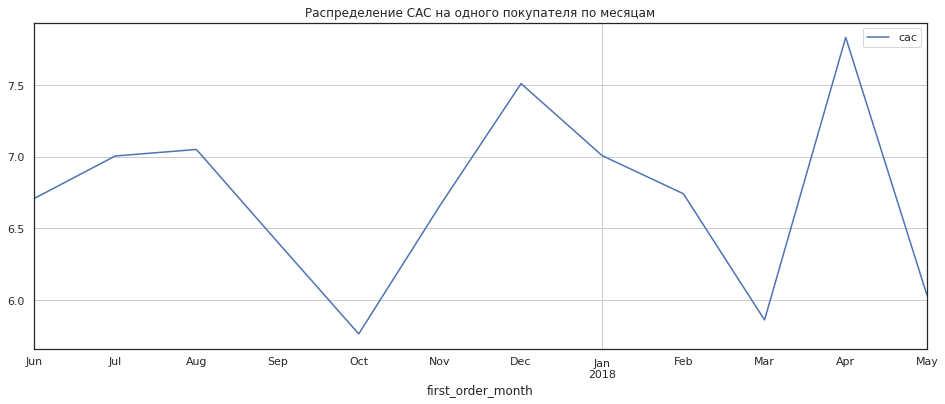

In [112]:
(report_new
     .pivot_table(index='first_order_month', values='cac', aggfunc='median')
     .plot(figsize=(16,6), legend=True, grid=True, title='Распределение CAC на одного покупателя по месяцам')
);

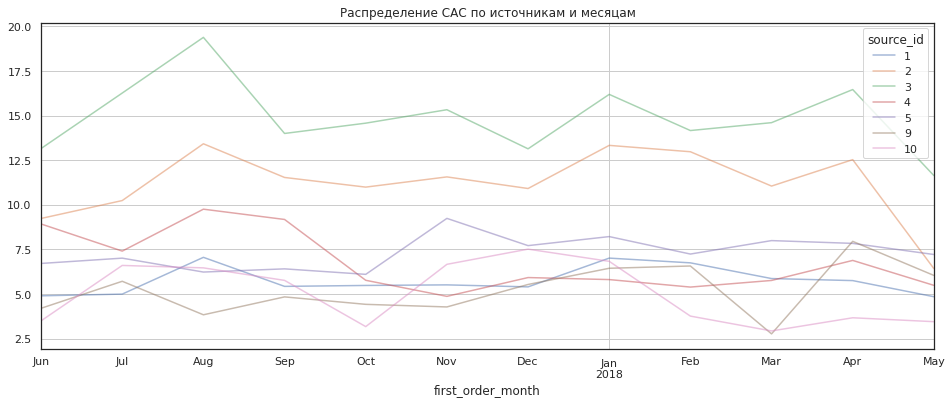

In [113]:
(report_new
      .pivot_table(index='first_order_month', columns='source_id', values='cac', aggfunc='median')
      .plot(kind='line', figsize=(16,6), legend=True, grid=True, alpha=0.5, title='Распределение САС по источникам и месяцам')
);

Сумма привлечения одного покупателя на сайт по всем источникам самой высокой была в начале рассматриваемого периода: в августе, самой низкой - в октябре. Средняя стоимость привлечения одного покуателя по всем источникам - 9 ден.ед., в среднем самый дорогой - 2 и 3 источники, самые дешевые: 1, 9 и 10. При анализе были рассмотренны медианные значения, дабы сократить влияние выбросов.


**[Расчёт ROMI](#romi)**

In [114]:
orders_romi = orders.merge(first_source_id, on=['uid'])
orders_romi

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month,first_source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06,2017-06,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06,2017-06,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06,2017-06,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06,2017-06,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06,2017-06,3
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05,2018-05,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05,2018-05,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05,2018-05,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05,2018-05,3


In [115]:
revenue_romi = orders_romi.groupby(['first_order_month', 'order_month', 'first_source_id']).agg({'uid': 'nunique', 'revenue' : 'sum'}).reset_index()
revenue_romi.columns = ['first_order_month', 'order_month', 'source_id', 'n_buyers2', 'revenue']

revenue_romi['first_order_month'] = revenue_romi['first_order_month'].astype('datetime64[M]')
revenue_romi['order_month'] = revenue_romi['order_month'].astype('datetime64[M]')
revenue_romi['age'] = (revenue_romi['order_month'] - revenue_romi['first_order_month']) / np.timedelta64(1, 'M')
revenue_romi['age'] = revenue_romi['age'].round().astype('int')

revenue_romi

,first_order_month,order_month,source_id,n_buyers2,revenue,age
0,2017-06-01,2017-06-01,1,230,1483.29,0
1,2017-06-01,2017-06-01,2,263,1352.36,0
2,2017-06-01,2017-06-01,3,588,2523.89,0
3,2017-06-01,2017-06-01,4,394,1873.67,0
4,2017-06-01,2017-06-01,5,390,1898.29,0
...,...,...,...,...,...,...
510,2018-05-01,2018-05-01,4,769,3632.15,0
511,2018-05-01,2018-05-01,5,509,2112.15,0
512,2018-05-01,2018-05-01,9,60,239.95,0
513,2018-05-01,2018-05-01,10,119,481.23,0


In [116]:
report_new2 = revenue_romi.merge(monthly_costs, on=['source_id', 'first_order_month'])

report_new2['cac'] = report_new2['costs'] / report_new2['n_buyers2']
report_new2['ltv'] = report_new2['revenue'] / report_new2['n_buyers2']
report_new2['romi'] = report_new2['ltv'] / report_new2['cac']

report_new2

,first_order_month,order_month,source_id,n_buyers2,revenue,age,costs,cac,ltv,romi
0,2017-06-01,2017-06-01,1,230,1483.29,0,1125.61,4.893957,6.449087,1.317765
1,2017-06-01,2017-07-01,1,17,275.83,1,1125.61,66.212353,16.225294,0.245049
2,2017-06-01,2017-08-01,1,14,204.31,2,1125.61,80.400714,14.593571,0.181510
3,2017-06-01,2017-09-01,1,14,685.05,3,1125.61,80.400714,48.932143,0.608603
4,2017-06-01,2017-10-01,1,18,826.71,4,1125.61,62.533889,45.928333,0.734455
...,...,...,...,...,...,...,...,...,...,...
508,2018-05-01,2018-05-01,3,809,3127.12,0,9411.42,11.633399,3.865414,0.332269
509,2018-05-01,2018-05-01,4,769,3632.15,0,4214.21,5.480117,4.723212,0.861882
510,2018-05-01,2018-05-01,5,509,2112.15,0,3669.56,7.209352,4.149607,0.575587
511,2018-05-01,2018-05-01,9,60,239.95,0,362.17,6.036167,3.999167,0.662534


In [117]:
output = report_new2.pivot_table(
    index='first_order_month', columns='age', values='romi', aggfunc='mean'
)

#final_result = report_new.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')

#m6_cum_ltv = final_result.cumsum(axis=1).mean(axis=0)[5]
#print('Средний LTV за 6 месяцев после первой покупки:', m6_cum_ltv)

In [118]:
output.cumsum(axis=1).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.698622,0.775673,0.845359,1.02254,1.22769,1.36406,1.54901,1.65729,1.75965,1.87765,1.99019,2.06509
2017-07-01,0.795074,0.889883,1.07575,1.15003,1.19109,1.22291,1.25015,1.2775,1.32029,1.35308,1.38645,
2017-08-01,0.674891,0.734138,0.80363,0.855683,0.910588,0.944537,0.97777,1.02591,1.08048,1.10715,,
2017-09-01,0.699627,0.84803,0.914168,1.30701,1.35249,1.4277,1.51702,1.54307,1.57159,,,
2017-10-01,0.809313,0.898432,0.931504,0.955699,0.978812,1.00678,1.01821,1.03582,,,,
2017-11-01,0.740006,0.79365,0.827732,0.878025,0.90107,0.911558,0.925859,,,,,
2017-12-01,0.642273,0.682349,0.820777,0.983521,1.02988,1.07546,,,,,,
2018-01-01,0.499962,0.546113,0.584769,0.610116,0.617611,,,,,,,
2018-02-01,0.591968,0.6227,0.632436,0.648036,,,,,,,,


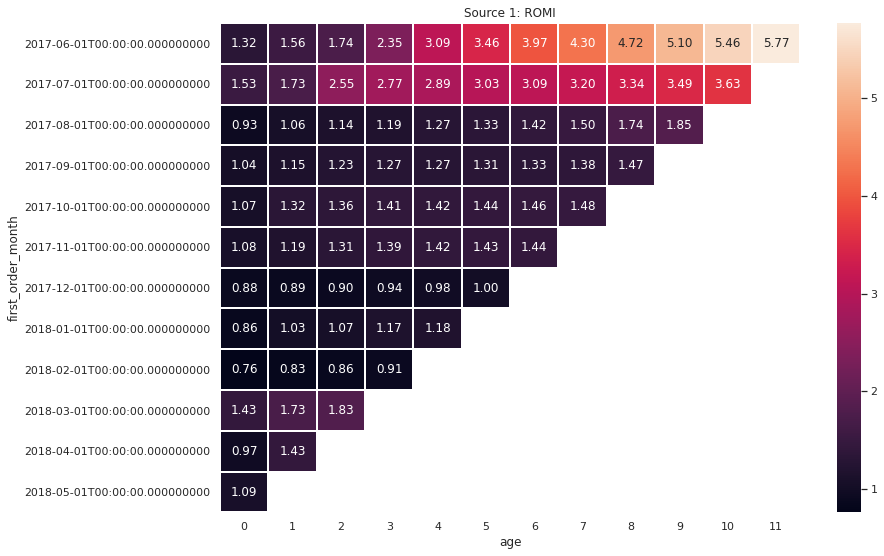

In [119]:
#report_new_source1 = pd.merge(report_new2, monthly_costs, left_on='first_order_month', right_on='month')
report_new_source1 = report_new2.query('source_id == "1"')

"""margin_rate = 1

report_new_source1['gp'] = report_new_source1['revenue'] * margin_rate
report_new_source1['age'] = (report_new_source1['order_month'] - report_new_source1['first_order_month']) / np.timedelta64(1, 'M')
report_new_source1['age'] = report_new_source1['age'].round().astype('int')
report_new_source1['ltv'] = report_new_source1['gp'] / report_new_source1['n_buyers2']
report_new_source1['cac'] = report_new_source1['costs'] / report_new_source1['n_buyers2']
report_new_source1['romi'] = report_new_source1['ltv'] / report_new_source1['cac']"""

output_source1 = report_new_source1.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
output_source1 = output_source1.cumsum(axis=1).round(2)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Source 1: ROMI')
sns.heatmap(output_source1, annot=True, fmt='.2f', linewidths=1, linecolor='white')


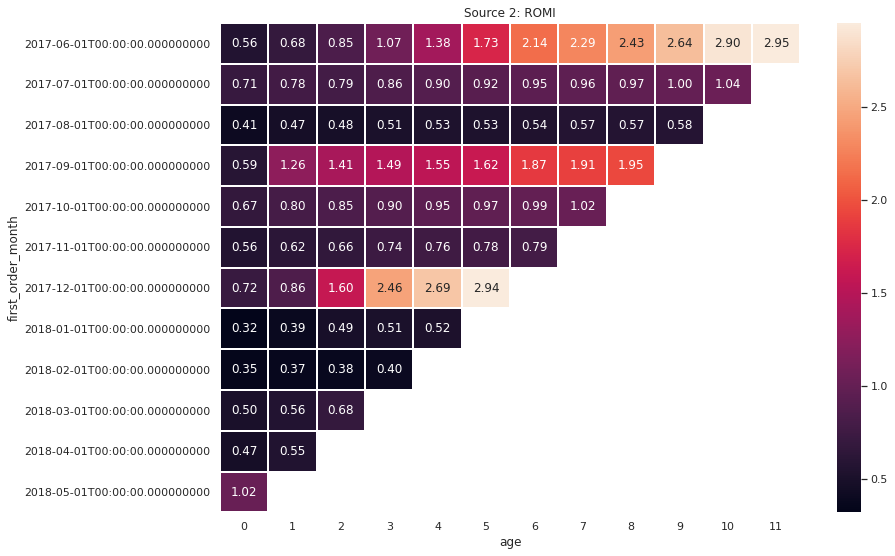

In [120]:
#report_new_source2 = pd.merge(report_new2, monthly_costs, left_on='first_order_month', right_on='month')
report_new_source2 = report_new2.query('source_id == "2"')

"""margin_rate = 1

report_new_source2['gp'] = report_new_source2['revenue'] * margin_rate
report_new_source2['age'] = (report_new_source2['order_month'] - report_new_source2['first_order_month']) / np.timedelta64(1, 'M')
report_new_source2['age'] = report_new_source2['age'].round().astype('int')
report_new_source2['ltv'] = report_new_source2['gp'] / report_new_source2['n_buyers']
report_new_source2['cac'] = report_new_source2['costs'] / report_new_source2['n_buyers']
report_new_source2['romi'] = report_new_source2['ltv'] / report_new_source2['cac']"""

output_source2 = report_new_source2.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
output_source2 = output_source2.cumsum(axis=1).round(2)
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Source 2: ROMI')
sns.heatmap(output_source2, annot=True, fmt='.2f', linewidths=1, linecolor='white')

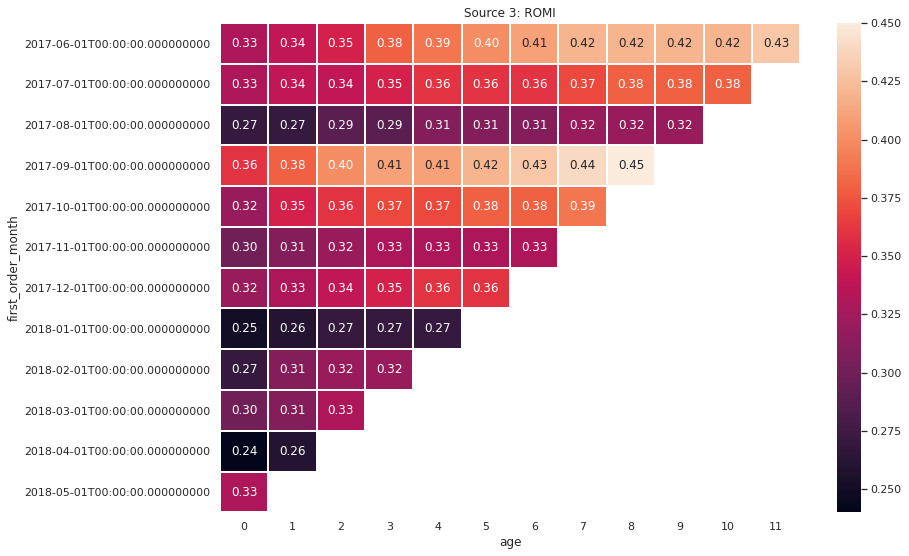

In [121]:
#report_new_source3 = pd.merge(report_new2, monthly_costs, left_on='first_order_month', right_on='month')
report_new_source3 = report_new2.query('source_id == "3"')

"""margin_rate = 1

report_new_source3['gp'] = report_new_source3['revenue'] * margin_rate
report_new_source3['age'] = (report_new_source3['order_month'] - report_new_source3['first_order_month']) / np.timedelta64(1, 'M')
report_new_source3['age'] = report_new_source3['age'].round().astype('int')
report_new_source3['ltv'] = report_new_source3['gp'] / report_new_source3['n_buyers']
report_new_source3['cac'] = report_new_source3['costs'] / report_new_source3['n_buyers']
report_new_source3['romi'] = report_new_source3['ltv'] / report_new_source3['cac']"""

output_source3 = report_new_source3.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
output_source3 = output_source3.cumsum(axis=1).round(2)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Source 3: ROMI')
sns.heatmap(output_source3, annot=True, fmt='.2f', linewidths=1, linecolor='white')

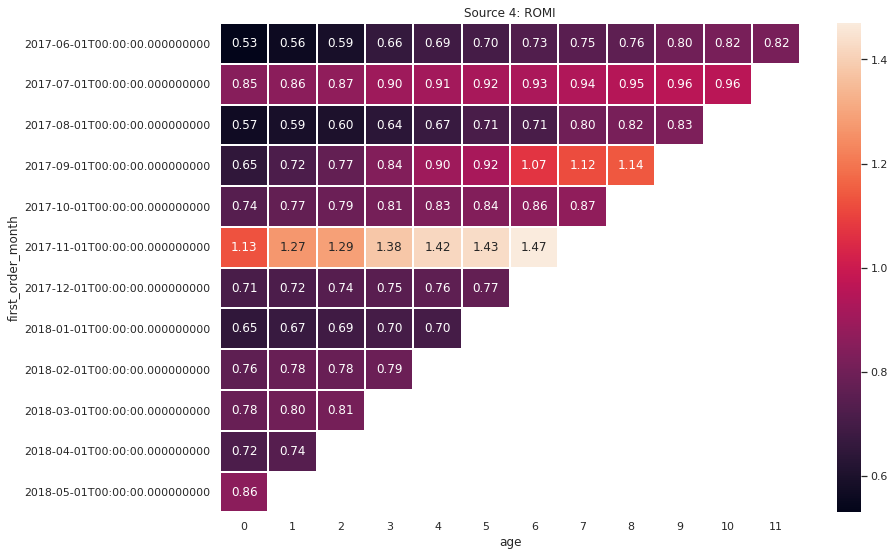

In [122]:
#report_new_source4 = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new_source4 = report_new2.query('source_id == "4"')

"""margin_rate = 1

report_new_source4['gp'] = report_new_source4['revenue'] * margin_rate
report_new_source4['age'] = (report_new_source4['order_month'] - report_new_source4['first_order_month']) / np.timedelta64(1, 'M')
report_new_source4['age'] = report_new_source4['age'].round().astype('int')
report_new_source4['ltv'] = report_new_source4['gp'] / report_new_source4['n_buyers']
report_new_source4['cac'] = report_new_source4['costs'] / report_new_source4['n_buyers']
report_new_source4['romi'] = report_new_source4['ltv'] / report_new_source4['cac']"""

output_source4 = report_new_source4.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
output_source4 = output_source4.cumsum(axis=1).round(2)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Source 4: ROMI')
sns.heatmap(output_source4, annot=True, fmt='.2f', linewidths=1, linecolor='white')

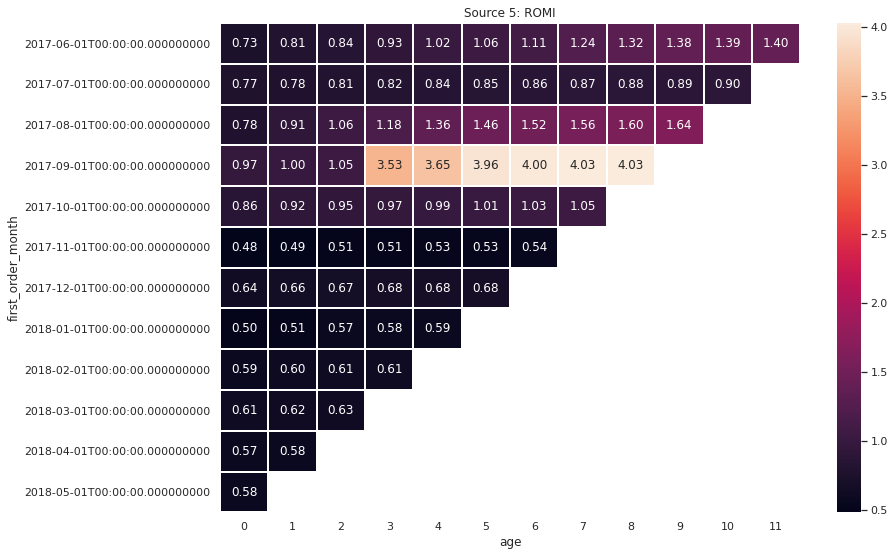

In [123]:
#report_new_source5 = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new_source5 = report_new2.query('source_id == "5"')

"""margin_rate = 1

report_new_source5['gp'] = report_new_source5['revenue'] * margin_rate
report_new_source5['age'] = (report_new_source5['order_month'] - report_new_source5['first_order_month']) / np.timedelta64(1, 'M')
report_new_source5['age'] = report_new_source5['age'].round().astype('int')
report_new_source5['ltv'] = report_new_source5['gp'] / report_new_source5['n_buyers']
report_new_source5['cac'] = report_new_source5['costs'] / report_new_source5['n_buyers']
report_new_source5['romi'] = report_new_source5['ltv'] / report_new_source5['cac']"""

output_source5 = report_new_source5.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
output_source5 = output_source5.cumsum(axis=1).round(2)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Source 5: ROMI')
sns.heatmap(output_source5, annot=True, fmt='.2f', linewidths=1, linecolor='white')

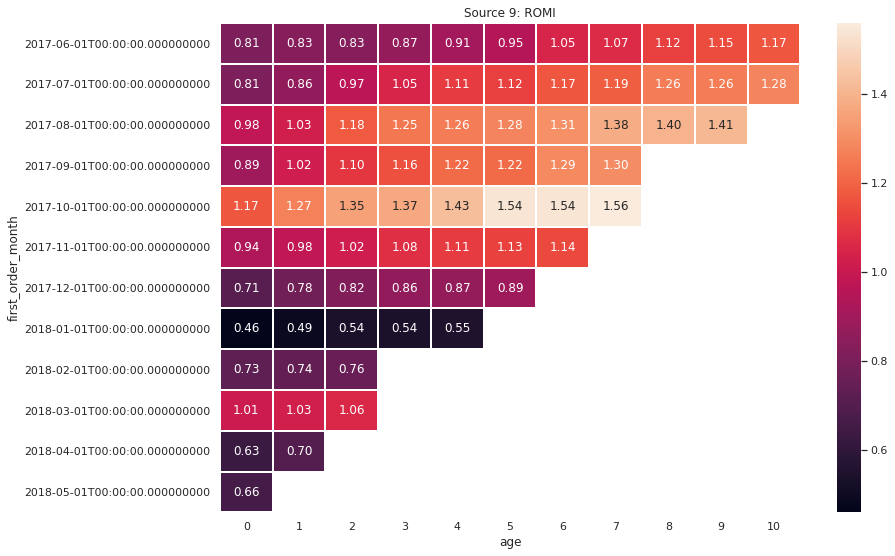

In [124]:
#report_new_source9 = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new_source9 = report_new2.query('source_id == "9"')

"""margin_rate = 1

report_new_source9['gp'] = report_new_source9['revenue'] * margin_rate
report_new_source9['age'] = (report_new_source9['order_month'] - report_new_source9['first_order_month']) / np.timedelta64(1, 'M')
report_new_source9['age'] = report_new_source9['age'].round().astype('int')
report_new_source9['ltv'] = report_new_source9['gp'] / report_new_source9['n_buyers']
report_new_source9['cac'] = report_new_source9['costs'] / report_new_source9['n_buyers']
report_new_source9['romi'] = report_new_source9['ltv'] / report_new_source9['cac']"""

output_source9 = report_new_source9.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
output_source9 = output_source9.cumsum(axis=1).round(2)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Source 9: ROMI')
sns.heatmap(output_source9, annot=True, fmt='.2f', linewidths=1, linecolor='white')

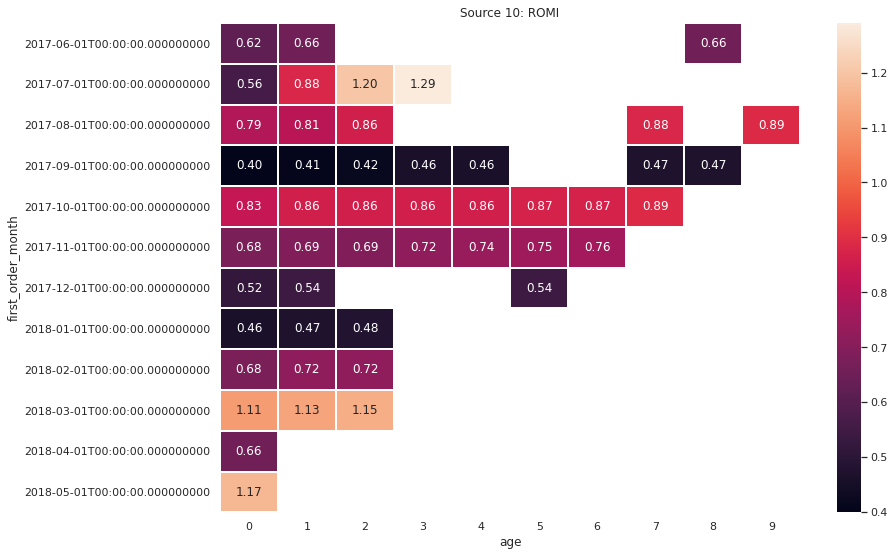

In [125]:
#report_new_source10 = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new_source10 = report_new2.query('source_id == "10"')

"""rgin_rate = 1

report_new_source10['gp'] = report_new_source10['revenue'] * margin_rate
report_new_source10['age'] = (report_new_source10['order_month'] - report_new_source10['first_order_month']) / np.timedelta64(1, 'M')
report_new_source10['age'] = report_new_source10['age'].round().astype('int')
report_new_source10['ltv'] = report_new_source10['gp'] / report_new_source10['n_buyers']
report_new_source10['cac'] = report_new_source10['costs'] / report_new_source10['n_buyers']
report_new_source10['romi'] = report_new_source10['ltv'] / report_new_source10['cac']"""

output_source10 = report_new_source10.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
output_source10 = output_source10.cumsum(axis=1).round(2)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Source 10: ROMI')
sns.heatmap(output_source10, annot=True, fmt='.2f', linewidths=1, linecolor='white')

В среднем и отдельно по каждому каналу наиболее высокий показатель окупаемости инвестиций в маркетинг - в сентябре 2017 года. Наиболее окупаемыми каналами являются 1,2 и 5. Вложения в маркетинг по 3 каналу является наиболее убыточным для продукта.



## [Вывод и рекомендации](#conclusion)

- Больше всего активности на сайте пользователи проявляли в конце ноября-декабре, в этот же период было потрачено больше всего на маркетинг;
- В среднем на сайт люди заходят раз в день и проводят около 6 минут на нем;
- В среднем за полгода один пользовтаель приносит 8 денежных единиц;
- Средняя стоимость привлечения одного клиента - 28 ден.ед.;
- На одного пользователя за полгода приходится 10 покупок;
- Коэффициент удержания с каждым месяцем снижается, что говорит о необходимость подкорректировать маркетинговые активности;
- Показтель среднего чека по месяцам говорит о 5 денежных единицах по большинству месяцов и 2633 - в предновогодний период;
- Сумма привлечения одного покупателя на сайт по всем источникам самой высокой была в августе, самой низкой - в октябре;
- Cамым дорогим каналом является 2 и 3 канал, самые дешевые: 1, 9 и 10;
- Самыми эффективными источниками привлечения клиентов являются 1 и 9 каналы, их следует развивать, а вот от 3 источника лучше отказаться, т.к. он не окупает себя.

